In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import scipy.stats as st
from scipy.optimize import minimize
import math
from multiprocessing import Pool
import emcee
import seaborn as sns
import pandas as pd # Import pandas to handle the data set

def Omega_k(Omega_m0, Omega_l0, Omega_r0):
    Omega_k0 = 1 - Omega_m0 - Omega_l0 - Omega_r0
    return Omega_k0

def E(x, Omega_m0,  Omega_l0,  Omega_r0):
    return np.sqrt(Omega_m0*(1+x)**3  + Omega_k(Omega_m0, Omega_l0, Omega_r0)*(1+x)**2 + Omega_l0)

def IntFunct(x, Omega_m0, Omega_l0, Omega_r0):
    return E(x, Omega_m0, Omega_l0, Omega_r0)**(-1)

def integral(z, Omega_m0, Omega_l0, Omega_r0):
    #return integrate.quad(IntFunct,0, z, args=(Omega_m0, Omega_l0, Omega_r0),epsabs=1.49e-4, epsrel=1.49e-03,full_output = 1)[0]
    return integrate.quad(IntFunct,0, z, args=(Omega_m0, Omega_l0, Omega_r0),epsabs=1.49e-4, epsrel=1.49e-03,full_output = 1)[0]

def distancia_luminosidad(z, h0, Omega_m0,  Omega_l0,  Omega_r0):
    
    c = 3 * 10**5 # km / s
    intl = integral(z, Omega_m0, Omega_l0, Omega_r0)
    
    if Omega_k(Omega_m0, Omega_l0, Omega_r0) < 0: # Abierto
        prefactor = c * (1 + z)/(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * h0)
        d_L = prefactor * np.sin(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * intl)
    elif Omega_k(Omega_m0, Omega_l0, Omega_r0) == 0: 
        d_L = c * (1 + z) * intl / h0
    else: # Cerrado
        prefactor = c * (1 + z)/(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * h0)
        d_L = prefactor * np.sinh(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * intl)
        
    return d_L

def mod_dist(z, h0, Omega_m0,  Omega_l0,  Omega_r0):
    
    c = 3 * 10**5 # km / s
    intl = integral(z, Omega_m0, Omega_l0, Omega_r0)
    
    if Omega_k(Omega_m0, Omega_l0, Omega_r0) < 0: # Abierto
        prefactor = c * (1 + z)/(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * h0)
        d_L = prefactor * np.sin(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * intl)
    elif Omega_k(Omega_m0, Omega_l0, Omega_r0) == 0: 
        d_L = c * (1 + z) * intl / h0
    else: # Cerrado
        prefactor = c * (1 + z)/(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * h0)
        d_L = prefactor * np.sinh(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * intl)
        
    return -5+5*np.log10(d_L*10**6)

mod_dist_vec = np.vectorize(mod_dist)

In [3]:
#Importing Data
z_mu= np.genfromtxt("jla_mub_0.csv", delimiter = ',')
cov_matrix = np.genfromtxt("jla_mub_covmatrix.csv", delimiter = ',').reshape(31,31)

z_exp = z_mu[:, 0] 
mu_exp = z_mu[:, 1]
mu_exp_err = np.sqrt(np.diagonal(cov_matrix))
print(mu_exp_err)

[0.14588565 0.16779608 0.07849893 0.07235392 0.08546065 0.05612508
 0.06106827 0.05676394 0.05679556 0.07514307 0.09290134 0.06208919
 0.06587934 0.05465046 0.05993366 0.03743409 0.03861412 0.03468859
 0.03214026 0.03296164 0.03171977 0.03926216 0.03357577 0.04152066
 0.03937127 0.03594528 0.06277785 0.05459144 0.06682761 0.15460364
 0.13845223]


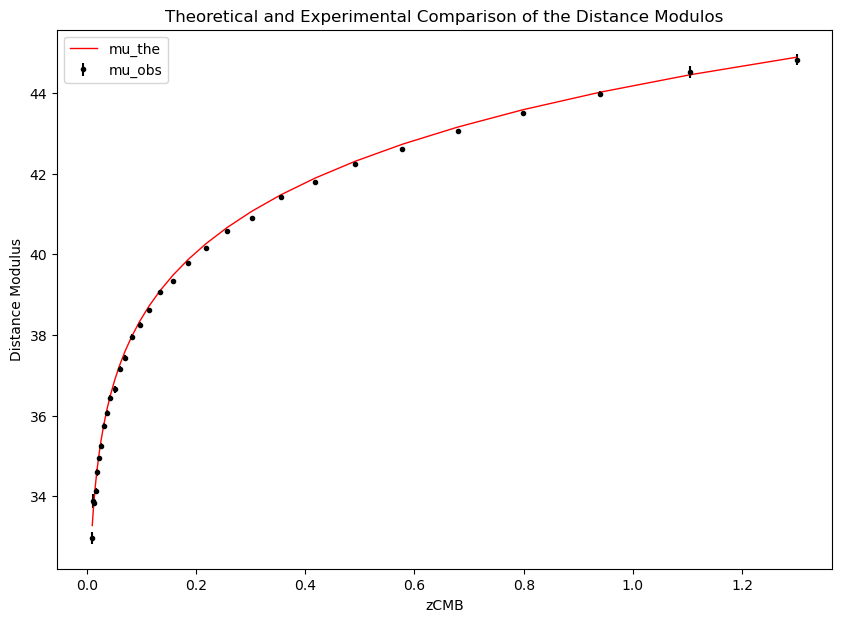

In [4]:
Omega_r0 = 0.0
Omega_m0 = 0.31
Omega_l0 = 0.69
h0 = 67 # km / s * Mpc

# Plot the theoretical experimental comparison of the distance modulos
plt.figure(figsize=(10,7))
# Plot the error bars
plt.errorbar(z_exp, mu_exp, yerr=mu_exp_err, fmt = ".k")
# Plot the true line
mu_theo=[mod_dist(z, h0, Omega_m0,  Omega_l0,  Omega_r0) for z in z_exp]
plt.plot(z_exp, mu_theo, "r", lw=1)
plt.title("Theoretical and Experimental Comparison of the Distance Modulos")
legend = ("mu_the","mu_obs")
plt.legend(legend)
plt.xlabel("zCMB")
plt.ylabel("Distance Modulus")
plt.savefig('dist_modulus.png')

# Importing the covarianze matrix

In [5]:
cov_inv = np.linalg.inv(cov_matrix) # Calculating the inverse matrix
cov_inv.shape

(31, 31)

In [6]:
cov_eigvals = np.linalg.eig(cov_matrix)[1] # Calculates the eigenvalues of the covariance matrix

In [7]:
def log_likelihood(theta, z_vec, mu_data, cov, cov_inv, cov_eigvals):
    """Compute the Gaussian log-likelihood for a given distance modulus data, distance modulus theorical and covariance."""
    h0, Omega_m0, Omega_l0 = theta 
    Omega_r0 = 0.0
    cov_len = len(cov)
    mu_model_array = mod_dist_vec(z_vec, h0, Omega_m0,  Omega_l0,  Omega_r0)
    return -0.5 * (np.matmul((mu_model_array - mu_data) , np.matmul(cov_inv , (mu_model_array - mu_data)))) - .5 * (np.sum(np.log(np.absolute(cov_eigvals[1]))) + cov_len * np.log(2*np.pi))

In [8]:
def log_prior(theta):
    h0, Omega_m0, Omega_l0 = theta # Parámetros a minimizar
    if 50< h0 < 100 and 0 < Omega_m0 < 1 and 0 < Omega_l0 < 1: # and and 0.0 < Omega_m0+Omega_l0+Omega_k(Omega_m0, Omega_l0, Omega_r0) <= 1.0
        return 0.0
    return -np.inf

def condition(theta, z):
    H, Omega_m0, Omega_l0 = theta
    
    z_max = np.max(z)
    result = Omega_m0*(1+z_max)**3  + Omega_k(Omega_m0, Omega_l0, Omega_r0)*(1+z_max)**2 + Omega_l0
    if result < 0:
        return -np.inf
    return result

def log_probability(theta, valores_z, distancia, error):
    if not np.isfinite(log_prior(theta)):
        lp = -np.inf
        return lp
    if not np.isfinite(condition(theta, valores_z)):
        lp = -np.inf
        return lp
    lp = 0.0
    Likelihood = log_likelihood(theta, z_vec, mu_data, cov, cov_inv, cov_eigvals) +lp
    return Likelihood # Si el valor de lp es finito, contruimos la funcion probabilidad

In [9]:
# Testing the log_likelihood:
mu_data = mu_exp
cov=cov_matrix
Omega_r0 = 0.0
Omega_m0 = 0.31
Omega_l0 = 0.69
h0 = 67 # km / s * Mpc
cov_inv = np.linalg.inv(cov)
cov_eigvals = np.linalg.eig(cov)
#mu_model_array=[mod_dist(z, h_guess, Omega_m_guess,  Omega_Lambda_guess,  Omega_r) for z in z_exp]
z_vec = z_exp
theta = (h0, Omega_m0, Omega_l0)
log_likelihood(theta, z_vec, mu_data, cov, cov_inv, cov_eigvals)

1593.0609834834706

In [10]:
max_n = 10000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

h0_random = np.random.uniform(50, 100, 100)
omega_m_random = np.random.uniform(0, 1, 100)
omega_lambda_random = np.random.uniform(0, 1, 100)
pos = []
pos = np.column_stack((h0_random, omega_lambda_random, omega_m_random)) # Escribe los 3 vectores como columnas
nwalkers, ndim = pos.shape  # nwalker y ndim toma el valor del número de filas y el número de columnas del vector "pos", respectivamente.


yerr = mu_exp_err

with Pool(processes=6) as pool:
    sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(z_vec, mu_data, yerr))
    # Now we'll sample for up to max_n steps
    for sample in sampler.sample(pos, iterations=max_n, progress=True):
        # Only check convergence every 100 steps
        if sampler.iteration % 100:
            continue

        # Compute the autocorrelation time so far
        # Using tol=0 means that we'll always get an estimate even
        # if it isn't trustworthy
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1

        # Check convergence
        # np.all() es una función de NumPy que devuelve True si todos los elementos en 
            # una matriz o expresión son evaluados como verdaderos, y False en caso contrario.
        # If the chain is longer than 100 times the estimated autocorrelation time and if 
            # this estimate changed by less than 1%, we’ll consider things converged.
        converged = np.all(sampler.iteration > 100 * tau)  
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01) 
        if converged:
            break
        old_tau = tau
        n = 100 * np.arange(1, index + 1)
        y = autocorr[:index]  
        plt.plot(n, n / 100.0, "--k", label = "Línea $\tau / 100$")
            # Pintamos la recta x = y / 100 porque una condición de convergencia es que 
            # la cadena sea 100 veces más larga que tau. De esta manera podremos
            # comprobarlo de manera más visual
        plt.plot(n, y, label = "$\tau$ calculada")
        plt.xlim(0, n.max())
        #plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
        plt.xlabel("Número de elementos de la cadena")
        plt.ylabel(r"$\hat{\tau}$ medio")
        file_name_fig = 'autocorrelation.pdf'
        plt.savefig(file_name_fig)
        plt.close()

        
n = 100 * np.arange(1, index + 1)
y = autocorr[:index]  
plt.plot(n, n / 100.0, "--k", label = r"Línea $\hat{\tau} / 100$")
     # Pintamos la recta x = y / 100 porque una condición de convergencia es que 
     # la cadena sea 100 veces más larga que tau. De esta manera podremos
     # comprobarlo de manera más visual
plt.plot(n, y, label = r"$\hat{\tau}$ calculado")
plt.xlim(0, n.max())
#plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
plt.xlabel("Número de elementos de la cadena")
plt.ylabel(r"$\hat{\tau}$ medio")
plt.legend(loc = "lower right")
file_name_fig = 'autocorrelation.pdf'
plt.savefig(file_name_fig)
plt.close()
plt.show()

 38%|███▊      | 3800/10000 [29:00<47:20,  2.18it/s]  


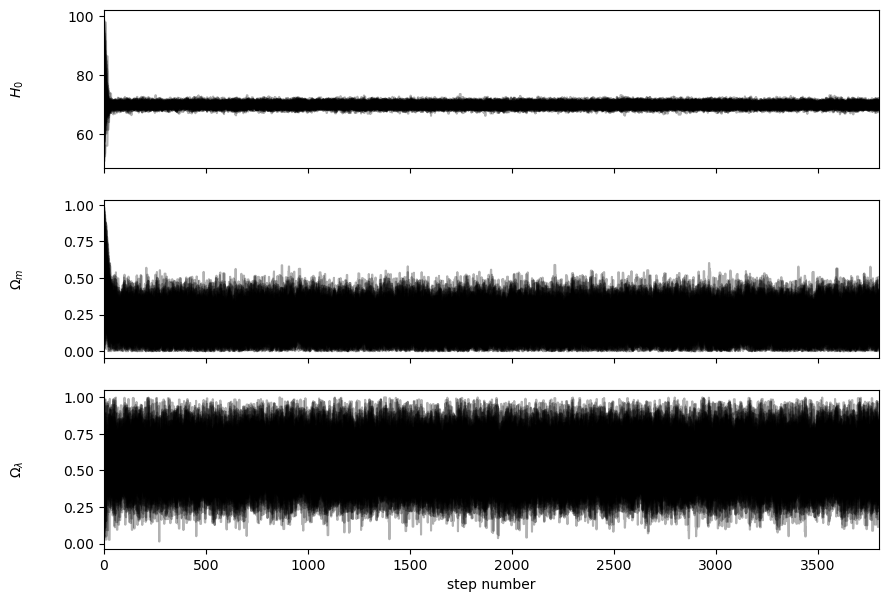

In [11]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$H_0$", "$\Omega_m$", "$\Omega_\lambda$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
file_name_fig = 'samples.pdf'
plt.savefig(file_name_fig)

In [14]:
tau = sampler.get_autocorr_time()  # autocorrelation
burnin = int(2 * np.max(tau))  # burn in phase
thin = int(0.5 * np.min(tau))  
print("burnin: ", burnin)
print("thin: ", thin)
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print("tau: ", tau)
print("--------")
print("samples shape: ", samples.shape)
print("flat samples shape: ", flat_samples.shape)
np.savetxt("flat_samples_jla_noflat.csv", flat_samples, delimiter = ',')


burnin:  73
thin:  15
tau:  [30.87480761 36.86103238 35.8500237 ]
--------
samples shape:  (3800, 100, 3)
flat samples shape:  (24800, 3)


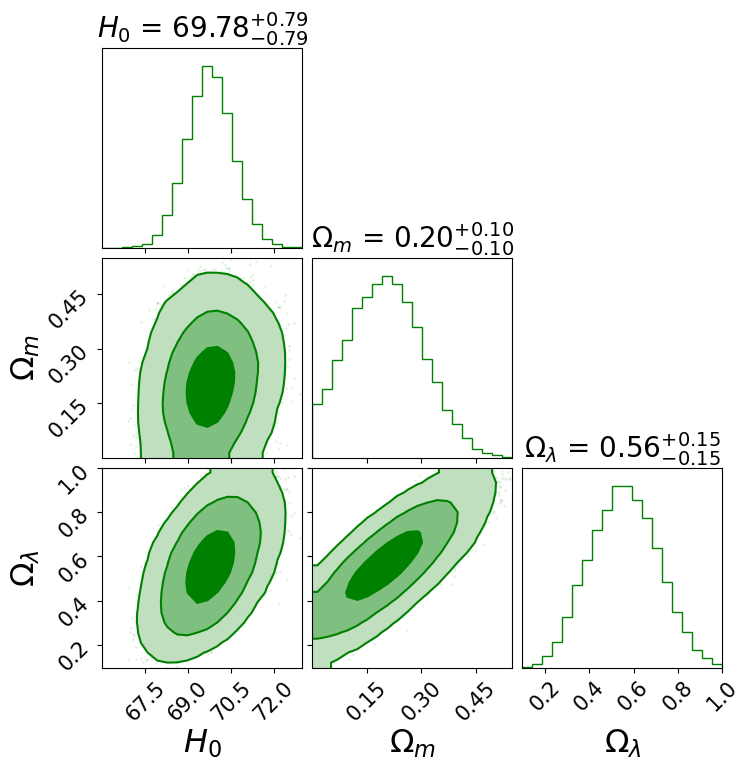

In [15]:
import corner
import numpy as np
# Parámetros del modelo

#valores "reales"
Omega_r0 = 0.0
Omega_m0 = 0.31
Omega_l0 = 0.69
h0 = 67 # km / s * Mpc

flat_samples = np.genfromtxt("flat_samples_jla_noflat.csv", delimiter = ',')
labels = ["$H_0$", "$\Omega_m$", "$\Omega_\lambda$"]
fig = corner.corner(flat_samples, labels=labels,fill_contours=True,bins=20, color='green', show_titles=True,smooth=1.0, 
                        label_kwargs={"fontsize": 23},title_kwargs={"fontsize": 20}, tick_kwargs={"fontsize": 30},
                        levels=(1-np.exp(-0.5),1-np.exp(-2.0),1-np.exp(-4.5)), range =((66, 73), (0, 0.55), (0.1, 1)))

fontsize = 15
for ax in fig.get_axes():
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
fig.savefig('corner_jla_noflat.pdf')

In [16]:
from IPython.display import display, Math

results = []
for i in range(3):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    print(mcmc)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    append = [mcmc[1], q[0], q[1]]
    results.append(append)
    display(Math(txt))
np.savetxt('Resultados_jla_noflat.csv', results, delimiter=',')
    

[68.98386887 69.7772697  70.57126432]


<IPython.core.display.Math object>

[0.09844128 0.20089614 0.30510111]


<IPython.core.display.Math object>

[0.40344461 0.55818895 0.71133097]


<IPython.core.display.Math object>